# Jason Pettinato HW2
I joined the class late, so this homework is probably late. I have been working hard to catch up on the lectures and homework 1, I hope that I will not lose credit / my extension days. Thank you
email: jpettinato@umass.edu

# Q1

For each $x_i$, the corresponding output $y_i$ is distributed as

$y_i = s x_i + \epsilon_i$,

where $\epsilon_i$ is standard Gaussian noise, and each $\epsilon_i$ is independent.

You also happen to know that the true slope is one of

$s \in [0,0.25, 0.5, 0.75, 1.0]$,

and that each of these slopes is, a-priori, equally likely.


Write a short program to calculate the probability of each s given the data. You can use the fact that

$p(s \vert x, y) \propto p(s) \prod_{i=1}^6 p(y_i \vert x_i, s),$


$p(y_i \vert x_i, s) = \mathrm{normal}(y_i \vert s \times x_i,1).$


Include the full code to calculate the answer directly in your report, along with the numbers you calculate (you should give 5 numbers that are all non-negative and sum to one).

In [3]:
from scipy.stats import norm

# Our data
x = [1, 2, 3, 4, 5, 6]
y = [0, 1.5, 1.0, 0.5, 1.2, 2.5]

# Our slope for y=mx+b is one of these
s_values = [0,0.25, 0.5, 0.75, 1.0]

# Posterior
s_predictions = []

# Based on the data, find p(s|x,y)

# Prior probability that any s_i is the true value
s_uniform = 1/len(s_values) 

for s in s_values:
    # Mean for p(y), as the error is normal about the value s*x
    y_mean = [s * x_i for x_i in x] 

    # p(x|x,s)
    y_likelihoods = norm.pdf(y, loc=y_mean, scale=1)

    # For each s, we take the product of all array elements
    y_likelihood = y_likelihoods.prod()

    # The posterior is the product of s, and the likelihood of y (given s).
    posterior = y_likelihood * s_uniform

    # Save the data for the given s
    s_predictions.append(posterior)

# The probability of any s, out of all s 
s_predictions = [p / sum(s_predictions) for p in s_predictions]

# Printing the outputs
for i, s in enumerate(s_values):
    print(f"P(s={s} | data) = {s_predictions[i]:.3f}")

# Check that the probabilities sum to 1
print(f"\nSum of probabilities: {sum(s_predictions):.3f}")

P(s=0 | data) = 0.009
P(s=0.25 | data) = 0.775
P(s=0.5 | data) = 0.215
P(s=0.75 | data) = 0.000
P(s=1.0 | data) = 0.000

Sum of probabilities: 1.000


# Q2

Write Pangolin code to calculate the answer in the previous question. Include in your report your code as well as the calculated posterior probabilities.

In [22]:
# Question 2

import pangolin as pg

# Our s options
s_values = [0.0, 0.25, 0.5, 0.75, 1.0]

# Prior distribution
s = pg.categorical([1/5] * 5)

# Make an rv, so we can use pangolin
s_value_options = pg.makerv(s_values)

# Link our s values to the uniform distribution
s_value = s_value_options[s]

# Givens, make x a rv for pangolin looping
x = pg.makerv([1, 2, 3, 4, 5, 6]) 
y_observed = [0, 1.5, 1.0, 0.5, 1.2, 2.5]  

# For looping
y_models = pg.slot() 

# We get our likelihood of y from each s
with pg.Loop(6) as i:
    y_models[i] = pg.normal(s_value * x[i], 1)


# We need to sample to estimate our posterior probabiliy for each s
n_samples = 10000
s_samples = pg.sample(s, y_models, y_observed, niter=n_samples)


# Make a posterior probability for the below loop
posterior = {s_val: 0 for s_val in s_values}

print(s_samples)

# Here we find out the probability of each s, from our sample s_values - trained on the given data
for idx, s_val in enumerate(s_values):
    count = sum(1 for sample in s_samples if sample == idx)
    posterior[s_val] = count / n_samples

total = 0
print("Posterior probabilities for each slope s given the data:")
for s_val in s_values:
    print(f"s = {s_val}: p(s | data) = {posterior[s_val]:.4f}")
    total +=posterior[s_val]

print(f"The probabilities all sum to one: {total}")


[1 1 1 ... 2 1 1]
Posterior probabilities for each slope s given the data:
s = 0.0: p(s | data) = 0.0092
s = 0.25: p(s | data) = 0.7735
s = 0.5: p(s | data) = 0.2173
s = 0.75: p(s | data) = 0.0000
s = 1.0: p(s | data) = 0.0000
The probabilities all sum to one: 1.0


# Q3

Now, suppose that the slope $s$ can be any real number between 0 and 1 (all equally likely). Give a program (using Pangolin) to draw samples from the posterior and make a histogram of the results.

(Hint: Use the `density=True` and `bins=100` when calling `matplotlib.pyplot.hist`.)

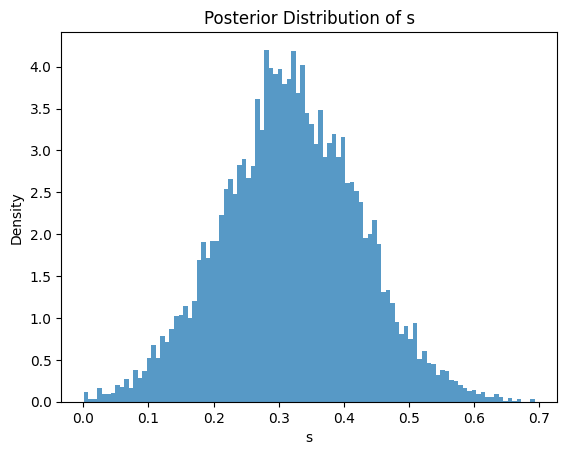

Posterior Mean of s: 0.3192
Posterior Std Dev of s: 0.1052


In [23]:
import pangolin as pg
import matplotlib.pyplot as plt

# Make our prior
s = pg.uniform(0, 1)

# Givens
x = pg.makerv([1, 2, 3, 4, 5, 6])
y_observed = [0, 1.5, 1.0, 0.5, 1.2, 2.5]

# For looping...
y_models = pg.slot()

# Make 6 different disributions for each s
with pg.Loop(6) as i:
    y_models[i] = pg.normal(s * x[i], 1)

# We sample for each s, getting samples for our posterior
# pg.sample(sample, condition, value) --> pg.sample(prior, conditional, data)
s_samples = pg.sample(s, y_models, y_observed, niter=10000)

# With our sample, we can plot the density distribution of s, conditioned on the training data
plt.hist(s_samples, bins=100, density=True, alpha=0.75)
plt.title("Posterior Distribution of s")
plt.xlabel("s")
plt.ylabel("Density")
plt.show()

# Simple calcs.
mean_s = sum(s_samples) / len(s_samples)
std_s = (sum((si - mean_s) ** 2 for si in s_samples) / len(s_samples)) ** 0.5
print(f"Posterior Mean of s: {mean_s:.4f}")
print(f"Posterior Std Dev of s: {std_s:.4f}")


# Q4

Make a plot of lines drawn from the posterior (from Q3) on top of the data. You may use this code:

```python
import numpy as np
from matplotlib import pyplot as plt
plt.plot(x,y,'.')
for s in slope_samples[::100]:
    xs = np.arange(0,6,.1)
    plt.plot(xs, s*xs,'k-',alpha=0.1)

```

Include your plot in your solution.

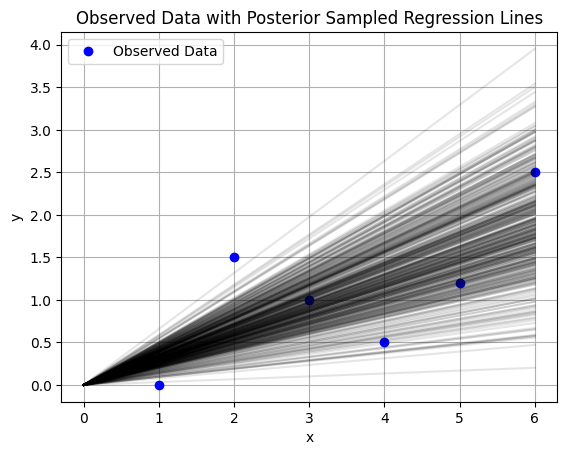

In [26]:
import numpy as np
import matplotlib.pyplot as plt
# given...
x_values = np.array([1, 2, 3, 4, 5, 6])
y_observed = np.array([0, 1.5, 1.0, 0.5, 1.2, 2.5])



# plot x,y as distinct points
plt.plot(x_values, y_observed, 'o', color='blue', label='Observed Data')

# In this loop we:
for s in s_samples[::25]: 
    xs = np.linspace(0, 6, 100) # sample x 
    ys = s * xs # get y from some s in s_samples
    plt.plot(xs, ys, 'k-', alpha=0.1) # plot the result

plt.title("Observed Data with Posterior Sampled Regression Lines")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


# Q5

Consider a slightly more complex model with both a slope s and a bias b:

$y_i = b + s x_i + \epsilon_i$

where the slope s can be any number between 0 and 1 (all equally likely), and the bias b can be any number between -1 and 1 (all equally likely).

Write a short Pangolin program to draw samples for b and s, conditioning on the observed data. Make a plot of the lines on top of the data. You may use this code:

```python
import numpy as np
from matplotlib import pyplot as plt
plt.plot(x,y,'.')
for (b, s) in zip(bias_samples[::100], slope_samples[::100]):
    xs = np.arange(0,6,.1)
    plt.plot(xs, b + s*xs,'k-',alpha=0.1)

```

Include your code as well as you plot in your solution.

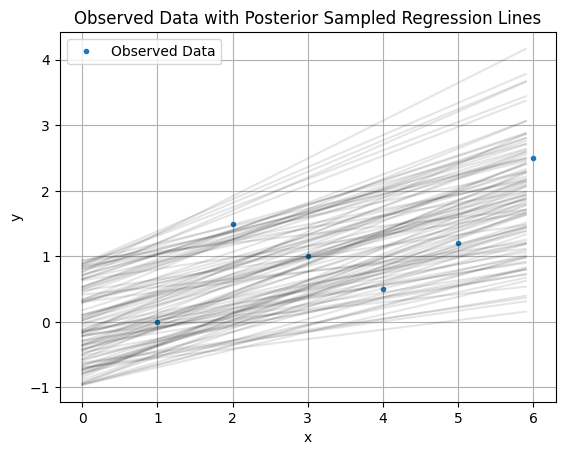

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import pangolin as pg

# This is given information
s = pg.uniform(0, 1)
b = pg.uniform(-1,1)

# Also given :)
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([0, 1.5, 1.0, 0.5, 1.2, 2.5])

# ...
x_rv = pg.makerv([1, 2, 3, 4, 5, 6])
y_observed = [0, 1.5, 1.0, 0.5, 1.2, 2.5]

y_models = pg.slot()

with pg.Loop(6) as i:
    y_models[i] = pg.normal(s * x_rv[i], 1) # the y model still only varies with s&x
    # even though b is introduced, it is fixed

# Getting our posterior
n_samples = 10000
# pg.sample(prior model, likelihood, data)
s_samples = pg.sample(s, y_models, y_observed, niter=n_samples)
b_samples = pg.sample(b, y_models, y_observed, niter=n_samples)

plt.plot(x,y,'.', label='Observed Data')
for (b, s) in zip(b_samples[::100], s_samples[::100]):
    xs = np.arange(0,6,.1)
    plt.plot(xs, b + s*xs,'k-',alpha=0.1)

plt.title("Observed Data with Posterior Sampled Regression Lines")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Q6

Load the diabetes dataset by running the code:

(Instruction to install the scikit-learn package into the python environment: `pip install scikit-learn`, more on page: https://scikit-learn.org/stable/install.html)

```python
import numpy as np
from sklearn.datasets import load_diabetes
X,y = load_diabetes(return_X_y=True)
y = y - np.mean(y)
y = y / np.std(y)

X_train = X[1::2]
X_test = X[::2]
y_train = y[1::2]
y_test = y[::2]

num_train, num_features = X_train.shape
num_test = X_test.shape[0]
```

Now, a simple model for this kind of data is a Bayesian linear regression model. This can be described mathematically as:

$w_d \sim \mathrm{normal}(0,10), d \in \{1, \cdots, D\}$,

$y_n \sim \mathrm{normal(w^\top x_n, 1)}, n \in \{1, \cdots, N_\mathrm{train}\}$

$y'_m \sim \mathrm{normal(w^\top x'_m, 1)}, m \in \{1, \cdots, N_\mathrm{test}\}.$

Here, $d$ indexes the dimensions of this model (the maximum $D$ is equal `num_features`). Meanwhile, n indexes the training data, and m indexes the different elements of the test data. All elements of both x and y are real numbers.

Write a short Pangolin model to predict the mean of the test data, given the training data i.e.

$\mathbb{E}[y' | x, y, x']$.

Make a scatter-plot of your predictions and the true values, with the true values on the x-axis, and the predictions on the y-axis. Finally, calculate the mean squared difference between your predictions and the true values. Include your full code directly in your report.

Hint: Your instructor's implementation uses less than 15 lines, not including blank lines.

In [32]:
import numpy as np
from sklearn.datasets import load_diabetes

# okay.. given ! :)
X,y = load_diabetes(return_X_y=True)
y = y - np.mean(y)
y = y / np.std(y)

X_train = X[1::2]
X_test = X[::2]
y_train = y[1::2]
y_test = y[::2]

num_train, num_features = X_train.shape
num_test = X_test.shape[0]
print(X_train.shape)
# D = 10
# N_train == N_test = 221

(221, 10)


c:\Users\jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The MSE is: 0.5528184771537781


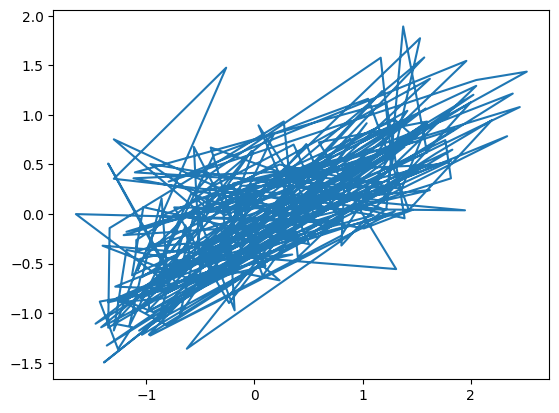

In [2]:
import pangolin as pg
import matplotlib.pyplot as plt

# Define Pangolin variables for loopin
w_models = pg.slot()
yn = pg.slot()
ym = pg.slot()

x_train_pg = pg.makerv(X_train)
x_test_pg = pg.makerv(X_test)

# For each feature, we have an identical normal dist
with pg.Loop(num_features) as d:
    w_models[d] = pg.normal(0, 10)

# This is the way
train_prod = pg.matmul(x_train_pg, w_models)
test_prod = pg.matmul(x_test_pg, w_models) 

# We get out likelihoods as:
with pg.Loop(num_train) as n:
    yn[n] = pg.normal(train_prod[n], 1)
    ym[n] = pg.normal(test_prod[n], 1)


 # pg.E, pg.sample --> (sample, condition, value)
y_pred = pg.E(ym, yn, y_train,  niter=100000 )

# As asked, we plot y' vs. y_predicted
plt.plot(y_test,y_pred'.', label='Comparison')

# MSE
mse = sum((y_test - y_pred)**2 for y_test, y_pred in zip(y_test, y_pred)) / len(y_test)
print(f"The MSE is: {mse}")

# Q7

Load the breast cancer dataset by running the code:

```python
from sklearn.datasets import load_breast_cancer
X,y = load_breast_cancer(return_X_y=True)

X_train = X[1::2]
X_test = X[::2]
y_train = y[1::2]
y_test = y[::2]

num_train, num_features = X_train.shape
num_test = X_test.shape[0]
```

Now, a simple model for this kind of data is a Bayesian logistic regression model. This can be described mathematically as:

$w_d \sim \mathrm{normal}(0,10), d \in \{1, \cdots, D\},$
#
$y_n \sim \mathrm{beroulli(sigmoid(w^\top x_n))}, n \in \{1, \cdots, N_\mathrm{train}\}$

$y'_m \sim \mathrm{bernoulli(sigmoid(w^\top x'_m))}, m \in \{1, \cdots, N_\mathrm{test}\}.$

Here, $d$ indexes the dimensions of this model (the maximum D is equal to `num_features`). Meanwhile, n indexes the training data, and m indexes the different elements of the test data. The $\mathrm{sigmoid}$  function maps real numbers to the 0-1 interval.

Write a short Pangolin model to predict the mean of the test data, given the training data i.e.

$\mathbb{E}[y' | x, y, x']$.

**Make two histograms: One for your predicted values for all elements where $y'_m=0$ and one for all elements where $y'_m=1$. Include your full code directly in your report.**

Hint: Your instructor's implementation uses less than 15 lines, not including inputs.

Hint: When computing expectations of $y’_m$, you will need to use a little trick: $\mathbb{E}[y'_m | x, y, x']=\mathbb{E}[ \mathrm{sigmoid}(w^\top x'_m) | x, y, x']$. You should use use the latter form rather than the first form, to get around a limitation of the capabilities of the underlying inference engine. More details on this are discussed in the [Loops in Pangolin lecture](https://www.notion.so/Videos-88cdfb7b078644379357cbc71d320ce0?pvs=21).

Hint: You only need a single call to `pangoin.E`.

In [8]:
from sklearn.datasets import load_breast_cancer
X,y = load_breast_cancer(return_X_y=True)

X_train = X[1::2]
X_test = X[::2]
y_train = y[1::2]
y_test = y[::2]

num_train, num_features = X_train.shape
num_test = X_test.shape[0]
print(y_train.shape)


(284,)


In [11]:

import pangolin as pg
import matplotlib.pyplot as plt

# For looping
w_models = pg.slot()
yn = pg.slot()
ym = pg.slot()
y_sig = pg.slot()

# For pangolin
x_train_pg = pg.makerv(X_train)
x_test_pg = pg.makerv(X_test)

# Sigmoid definition
def sigmoid(a):
    return 1/(1+pg.exp(-a))

# Making our 10 dists.
with pg.Loop(num_features) as d:
    w_models[d] = pg.normal(0, 10)

# We do this to avoid pain (wt * x)
train_prod = pg.matmul(x_train_pg, w_models)
test_prod = pg.matmul(x_test_pg, w_models) 


with pg.Loop(num_train) as n:
    yn[n] = pg.bernoulli(sigmoid(train_prod[n]))

# Getting our likelihoods
with pg.Loop(num_test) as n:
    ym[n] = pg.bernoulli(sigmoid(test_prod[n]))
    y_sig[n] = sigmoid(test_prod[n])



# Compute expected values of y_sig from our model and given data
y_pred = pg.E(y_sig, yn, y_train, niter=10000)

[1.0000000e+00 9.9966180e-01 4.1189364e-06 3.8039542e-18 9.9974424e-01
 3.9483023e-21 9.1600678e-11 1.7864685e-12 1.0000000e+00 6.2365834e-05
 5.1920680e-13 6.5004189e-09 2.5473467e-01 5.5184105e-22 1.4221599e-10
 2.4326530e-01 1.0000000e+00 1.0177125e-20 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.4258236e-04 1.0000000e+00 7.5002971e-10 1.0754805e-14
 2.0512023e-03 6.5948311e-03 1.1475239e-02 1.0000000e+00 8.1388550e-18
 6.0248088e-16 5.8250811e-18 2.7312813e-12 8.7995249e-01 1.0543643e-09
 3.1847982e-17 9.9970591e-01 9.8401600e-01 7.1557462e-01 2.1997676e-06
 1.0000000e+00 2.3934370e-18 1.3596069e-24 3.0044572e-22 2.6200311e-17
 3.0909188e-18 9.9996305e-01 1.2153680e-13 1.0000000e+00 1.0570902e-08
 9.9999374e-01 1.7608711e-01 6.3091896e-02 2.9625963e-22 1.0000000e+00
 2.9831368e-21 5.9138429e-01 1.0000000e+00 1.0000000e+00 9.9999863e-01
 2.2410976e-02 1.0000000e+00 1.1270654e-01 9.6037465e-25 2.0338295e-16
 1.0000000e+00 1.9416460e-04 1.1734366e-04 9.0886129e-27 1.0000000e+00
 9.951

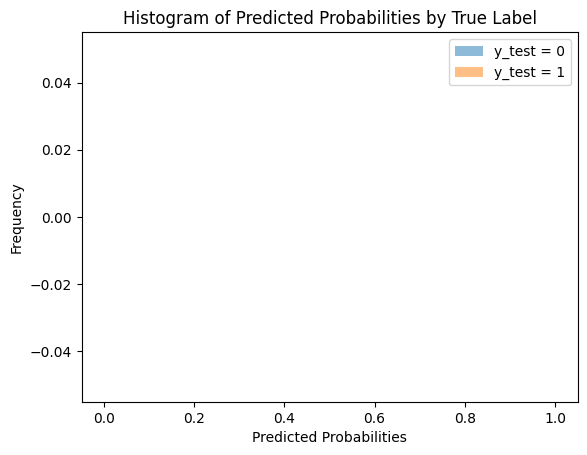

Mean Squared Error: 0.92311114


In [16]:
print(y_pred)
print(y_test)

plt.hist(y_pred[y_test == 0], bins=20, alpha=0.5, label='y_test = 0')
plt.hist(y_pred[y_test == 1], bins=20, alpha=0.5, label='y_test = 1')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities by True Label')
plt.legend()
plt.show()

# Calculate the mean squared error between predicted probabilities and true labels
mse = sum((y_test - y_pred)**2 for y_test, y_pred in zip(y_test, y_pred)) / len(y_test)
print('Mean Squared Error:', mse)